This notebook show an example on how to train a lgsegmentor multi-axis multi-plane Unet and MLP classifer (lgsegmentor) from a single data volume with 3 classes

In [19]:
import numpy as np
import tifffile
import napari
import leopardgecko.segmentor as lgs

import logging
logging.basicConfig(level=logging.INFO)

# Load data and respective labels

data and labels filenames as a tuple. This is not required but it makes it easier to setup training with multiple volumes

In [4]:
data_labels_fn=[
    ("test_data/TS_0005_crop.tif", "test_data/TS_0005_membranes_crop.tif"),
]

In [5]:
traindatas=[]
trainlabels=[]

for datafn0, labelfn0 in data_labels_fn:
     #Make sure data and labels are curated in the correct data format
    traindatas.append(tifffile.imread(datafn0))
    trainlabels.append(tifffile.imread(labelfn0)) #In this case labels are already in uint8

# Setup lg segmentor

In [8]:
#Create the class
lgsegmentor0 = lgs.cMultiAxisRotationsSegmentor()

Check default settings and modify as needed

In [10]:
lgsegmentor0.NN1_train_settings #default NN1 settings

namespace(data_im_dirname='data',
          seg_im_out_dirname='seg',
          model_output_fn='trained_2d_model',
          clip_data=False,
          st_dev_factor=2.575,
          data_hdf5_path='/data',
          seg_hdf5_path='/data',
          training_axes='All',
          image_size=256,
          downsample=False,
          training_set_proportion=0.8,
          cuda_device=0,
          num_cyc_frozen=8,
          num_cyc_unfrozen=5,
          patience=3,
          loss_criterion='DiceLoss',
          alpha=0.75,
          beta=0.25,
          eval_metric='MeanIoU',
          pct_lr_inc=0.3,
          starting_lr='1e-6',
          end_lr=50,
          lr_find_epochs=1,
          lr_reduce_factor=500,
          plot_lr_graph=False,
          model={'type': 'U_Net',
                 'encoder_name': 'resnet34',
                 'encoder_weights': 'imagenet'})

In [ ]:
# note that clip_data is false.

In [11]:
lgsegmentor0.NN1_train_settings.image_size=256 # size for unet input. Images with different pixelsize will be resized before training

lgsegmentor0.NN1_train_settings.clip_data=True #  Data has negative values so either we normalise to int or we can set clip_data to True
#lgsegmentor0.NN1_train_settings.clip_data=False # data has already been normalised, so clipping is not needed, neither is desired

lgsegmentor0.NN1_train_settings.num_cyc_frozen=10
lgsegmentor0.NN1_train_settings.num_cyc_unfrozen=8

In [12]:
lgsegmentor0.NN2_settings

namespace(hidden_layer_sizes=[10, 10],
          activation='tanh',
          random_state=1,
          verbose=True,
          learning_rate_init=0.001,
          solver='sgd',
          max_iter=1000,
          ntrain=4096)

Set CUDA device.

To change cuda device don't change with .cuda_device, but rather use setcudadevice(devnumber)

You may want to check usage and memory-usage with command `!nvidia-smi` to see what is available before starting training

In [17]:
!nvidia-smi

Fri Sep 29 18:22:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:00:06.0 Off |                    0 |
| N/A   

In [18]:
lgsegmentor0.set_cuda_device(0)

Start training. It will take a while and will print a lot of messages. At the end `res` will contain metrics information

In [20]:
res= lgsegmentor0.train(traindatas, trainlabels, get_metrics=True)


100%|██████████| 4096/4096 [00:00<00:00, 109483.10it/s]


Iteration 1, loss = 0.40700302
Iteration 2, loss = 0.32256210
Iteration 3, loss = 0.29251975
Iteration 4, loss = 0.28058648
Iteration 5, loss = 0.27467091
Iteration 6, loss = 0.27108013
Iteration 7, loss = 0.26850536
Iteration 8, loss = 0.26660887
Iteration 9, loss = 0.26505528
Iteration 10, loss = 0.26372937
Iteration 11, loss = 0.26247604
Iteration 12, loss = 0.26137102
Iteration 13, loss = 0.26029623
Iteration 14, loss = 0.25926133
Iteration 15, loss = 0.25824656
Iteration 16, loss = 0.25725589
Iteration 17, loss = 0.25633865
Iteration 18, loss = 0.25528996
Iteration 19, loss = 0.25430826
Iteration 20, loss = 0.25330756
Iteration 21, loss = 0.25233390
Iteration 22, loss = 0.25135115
Iteration 23, loss = 0.25034471
Iteration 24, loss = 0.24936597
Iteration 25, loss = 0.24834289
Iteration 26, loss = 0.24728927
Iteration 27, loss = 0.24621188
Iteration 28, loss = 0.24517839
Iteration 29, loss = 0.24407370
Iteration 30, loss = 0.24298590
Iteration 31, loss = 0.24192987
Iteration 32, los

# Save model

It is standard practise to save with the date that the model was created

In [21]:
# lgsegmentor0.save_model("2023_06_12_endometrium.lgsegmod")
import datetime
model_save_fn = f"{datetime.date.today()}_ribos_membr.lgsegmod" #Choose correct description
lgsegmentor0.save_model(model_save_fn)

# Check how training metrics progressed during UNet training

plot should look like a exponential decaying to zero for both the training and validation loss

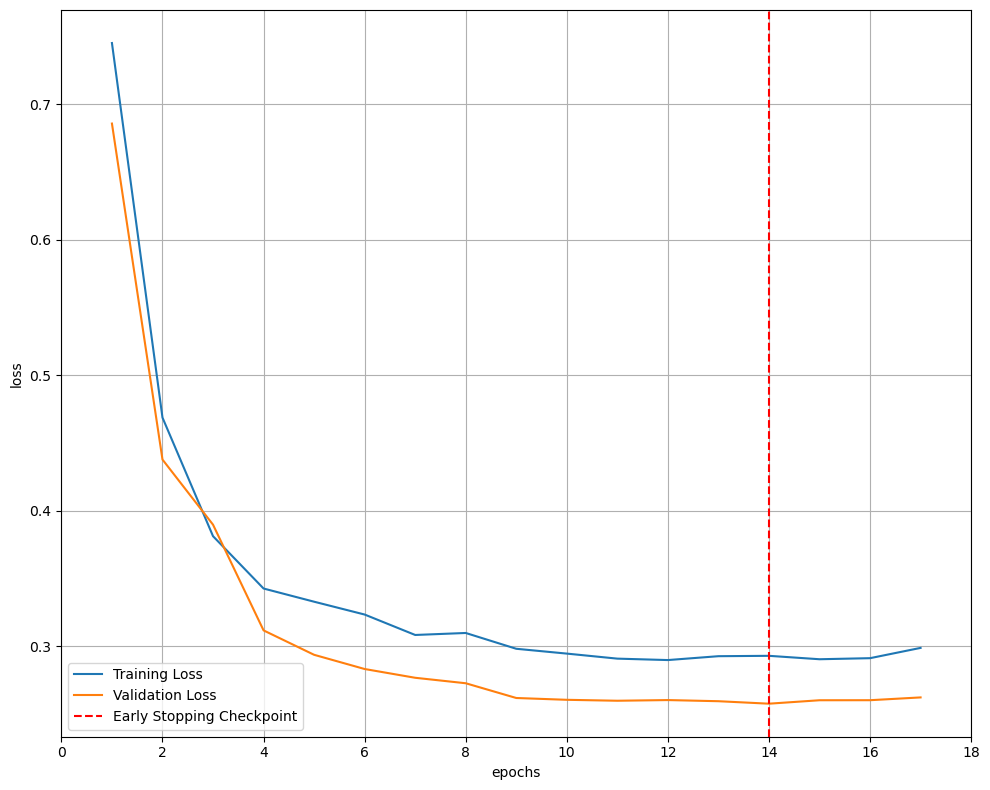

In [23]:
from pathlib import Path
lgsegmentor0.trainer.output_loss_fig(Path(model_save_fn))

# Training metrics

In [24]:
res

([[0.9522532224655151,
   (0.6221156032500919, {1: 0.5048071200348009, 2: 0.7394240864653827})],
  [0.9462607502937317,
   (0.5309814569079144, {1: 0.4107912065958215, 2: 0.6511717072200073})],
  [0.9442001581192017,
   (0.48581384849068954, {1: 0.34191985045898243, 2: 0.6297078465223966})],
  [0.949865460395813,
   (0.6060927643140974, {1: 0.4928745254755038, 2: 0.7193110031526911})],
  [0.9420268535614014,
   (0.4643937144876735, {1: 0.4016421002556238, 2: 0.5271453287197232})],
  [0.9421098232269287,
   (0.48020496656807066, {1: 0.32880944091508113, 2: 0.6316004922210602})],
  [0.9505653977394104,
   (0.604138123610397, {1: 0.4899386197983676, 2: 0.7183376274224264})],
  [0.9440448880195618,
   (0.47818565531025914, {1: 0.400889999397825, 2: 0.5554813112226933})],
  [0.9418398141860962,
   (0.4483205757124149, {1: 0.30636384670571765, 2: 0.5902773047191121})],
  [0.9524989724159241,
   (0.625402607874632, {1: 0.5208836214453523, 2: 0.7299215943039118})],
  [0.9461814165115356,
   (0

First element are accuracy and dice scores for NN1 predicted volumes, in each axis/direction

Second element are similar metrics but after the NN2 (complete lgsegmentor) inference (single volume).

In [25]:
res[0] #NN1 metrics

[[0.9522532224655151,
  (0.6221156032500919, {1: 0.5048071200348009, 2: 0.7394240864653827})],
 [0.9462607502937317,
  (0.5309814569079144, {1: 0.4107912065958215, 2: 0.6511717072200073})],
 [0.9442001581192017,
  (0.48581384849068954, {1: 0.34191985045898243, 2: 0.6297078465223966})],
 [0.949865460395813,
  (0.6060927643140974, {1: 0.4928745254755038, 2: 0.7193110031526911})],
 [0.9420268535614014,
  (0.4643937144876735, {1: 0.4016421002556238, 2: 0.5271453287197232})],
 [0.9421098232269287,
  (0.48020496656807066, {1: 0.32880944091508113, 2: 0.6316004922210602})],
 [0.9505653977394104,
  (0.604138123610397, {1: 0.4899386197983676, 2: 0.7183376274224264})],
 [0.9440448880195618,
  (0.47818565531025914, {1: 0.400889999397825, 2: 0.5554813112226933})],
 [0.9418398141860962,
  (0.4483205757124149, {1: 0.30636384670571765, 2: 0.5902773047191121})],
 [0.9524989724159241,
  (0.625402607874632, {1: 0.5208836214453523, 2: 0.7299215943039118})],
 [0.9461814165115356,
  (0.5205443752756955, {1:

In [26]:
res[1] #NN2 metrics

([0.9525130391120911],
 [(0.6279437691093606, {1: 0.5159169453734671, 2: 0.7399705928452541})])

We can also get some information of the NN1 predictions by looking at the dataframe that it generates

In [30]:
lgsegmentor0.all_nn1_pred_pd

,pred_data_probs_filenames,pred_data_labels_filenames,pred_sets,pred_planes,pred_rots,pred_ipred,pred_shapes,accuracy,dice
0,/tmp/tmpe8wakdun/pred_0_YX_0.h5,/tmp/tmpe8wakdun/pred_0_YX_labels_0.h5,0,YX,0,0,"(256, 256, 256)",0.952253,0.622116
1,/tmp/tmpe8wakdun/pred_0_ZX_0.h5,/tmp/tmpe8wakdun/pred_0_ZX_labels_0.h5,0,ZX,0,1,"(256, 256, 256)",0.946261,0.530981
2,/tmp/tmpe8wakdun/pred_0_ZY_0.h5,/tmp/tmpe8wakdun/pred_0_ZY_labels_0.h5,0,ZY,0,2,"(256, 256, 256)",0.944200,0.485814
3,/tmp/tmpe8wakdun/pred_0_YX_90.h5,/tmp/tmpe8wakdun/pred_0_YX_labels_90.h5,0,YX,90,3,"(256, 256, 256)",0.949865,0.606093
4,/tmp/tmpe8wakdun/pred_0_ZX_90.h5,/tmp/tmpe8wakdun/pred_0_ZX_labels_90.h5,0,ZX,90,4,"(256, 256, 256)",0.942027,0.464394
5,/tmp/tmpe8wakdun/pred_0_ZY_90.h5,/tmp/tmpe8wakdun/pred_0_ZY_labels_90.h5,0,ZY,90,5,"(256, 256, 256)",0.942110,0.480205
6,/tmp/tmpe8wakdun/pred_0_YX_180.h5,/tmp/tmpe8wakdun/pred_0_YX_labels_180.h5,0,YX,180,6,"(256, 256, 256)",0.950565,0.604138
7,/tmp/tmpe8wakdun/pred_0_ZX_180.h5,/tmp/tmpe8wakdun/pred_0_ZX_labels_180.h5,0,ZX,180,7,"(256, 256, 256)",0.944045,0.478186
8,/tmp/tmpe8wakdun/pred_0_ZY_180.h5,/tmp/tmpe8wakdun/pred_0_ZY_labels_180.h5,0,ZY,180,8,"(256, 256, 256)",0.941840,0.448321
9,/tmp/tmpe8wakdun/pred_0_YX_270.h5,/tmp/tmpe8wakdun/pred_0_YX_labels_270.h5,0,YX,270,9,"(256, 256, 256)",0.952499,0.625403


We can average the NN1 metrics and compare with the complete lgsegmentor

In [27]:
nn1_acc_avg= np.mean( [el0[0] for el0 in res[0]])
nn1_dice_avg= np.nanmean(np.array( [el0[1][0] for el0 in res[0]] ))

nn1nn2_acc_avg = np.mean(np.array(res[1][0]))
nn1nn2_dice_avg =np.nanmean( [dice_info[0] for dice_info in res[1][1]] )

In [28]:
print(nn1_dice_avg)
print(nn1nn2_dice_avg)

0.531423472336976
0.6279437691093606


There is a good improvement if the NN2 (MLP classifier) is used with multiple axis and rotations predictions compared with a single axis and rotation prediction.

In [29]:
print(nn1_acc_avg)
print(nn1nn2_acc_avg)

0.9463594655195872
0.9525130391120911


Accuracy is not a great metric unless the background is much smaller, but we can also see a small improvement.